In [1]:
import sys
sys.path.insert(1, 'E:/Research/course research projects/data-driven software engineering/gui-element-detection/src')

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
import requests
import numpy as np
import pandas as pd
from IPython.display import Image
from random import choice
import shutil

SEED = 42
np.random.seed(SEED)

from constants import VINS_MERGED_YOLO_FULL as dsPath

from constants import VINS_MERGED_YOLO_SPLIT_TEST_IMAGES as testImagePath
from constants import VINS_MERGED_YOLO_SPLIT_TRAIN_IMAGES as trainImagePath
from constants import VINS_MERGED_YOLO_SPLIT_VAL_IMAGES as valImagePath

from constants import VINS_MERGED_YOLO_SPLIT_TEST_LABELS as testLabelPath
from constants import VINS_MERGED_YOLO_SPLIT_TRAIN_LABELS as trainLabelPath
from constants import VINS_MERGED_YOLO_SPLIT_VAL_LABELS as valLabelPath

In [13]:
# !git clone https://github.com/ultralytics/yolov5

In [3]:
%cd yolov5

E:\Research\course research projects\data-driven software engineering\gui-element-detection\src\yolo\yolov5


In [15]:
# !pip install -r requirements.txt

In [16]:
from constants import TRAIN_SPLIT_RATIO, TEST_SPLIT_RATIO, VALIDATION_SPLIT_RATIO

imageCount = len(os.listdir(dsPath))//2

images = glob.glob(f"{dsPath}*.jpg")
xmls = glob.glob(f"{dsPath}*.txt")
assert len(images) == imageCount
assert len(xmls) == imageCount


trainCount = int(TRAIN_SPLIT_RATIO * imageCount)
valCount = int(VALIDATION_SPLIT_RATIO * imageCount)
testCount = int(TEST_SPLIT_RATIO * imageCount)

assert trainCount + valCount + testCount == imageCount

In [17]:
def copy_files_splits(count, data_paths:list[str], labels_paths:list[str], origin, data_destination, label_destination):
    label_type = labels_paths[0].split(".")[-1]
    data_type_length = len(data_paths[0].split(".")[-1])
    for i in range(count):
        raw_data_file = choice(data_paths)
        data_file = raw_data_file.replace("\\","/").split("/")[-1]
        raw_label_file = raw_data_file[:-(data_type_length + 1)] + "." + label_type
        label_file = raw_label_file.replace("\\","/").split("/")[-1]

        shutil.copy(os.path.join(origin,data_file),os.path.join(data_destination, data_file))
        shutil.copy(os.path.join(origin,label_file),os.path.join(label_destination, label_file))

        data_paths.remove(raw_data_file)
        labels_paths.remove(raw_label_file)


In [18]:
# Split the data (Physically) - YOLOv5 Limitation
# copy_files_splits(trainCount,images,xmls,dsPath,trainImagePath,trainLabelPath)
# copy_files_splits(testCount,images,xmls,dsPath,testImagePath,testLabelPath)
# copy_files_splits(valCount,images,xmls,dsPath,valImagePath,valLabelPath)
# assert len(images) + len(xmls) == 0 # all images were split into 3 categories


## The training phase is below

In [4]:
EPOCHS = 300
# TRAIN = False
TRAIN = False


In [5]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{EPOCHS}_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{EPOCHS}_{res_dir_count}"
    return RES_DIR

In [6]:
RES_DIR = set_res_dir()

Current number of result directories: 9


In [8]:
# the image size used in Yolov5 GUI detection paper was 416 with batches of 16

if TRAIN:
    !python train.py --data dataset.yaml --weights yolov5s.pt --img 416 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}



Current number of result directories: 4
results_300_5
^C


In [22]:
def show_valid_results(RES_DIR):
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

['runs/train/results_100_3\\val_batch0_pred.jpg', 'runs/train/results_100_3\\val_batch1_pred.jpg', 'runs/train/results_100_3\\val_batch2_pred.jpg']


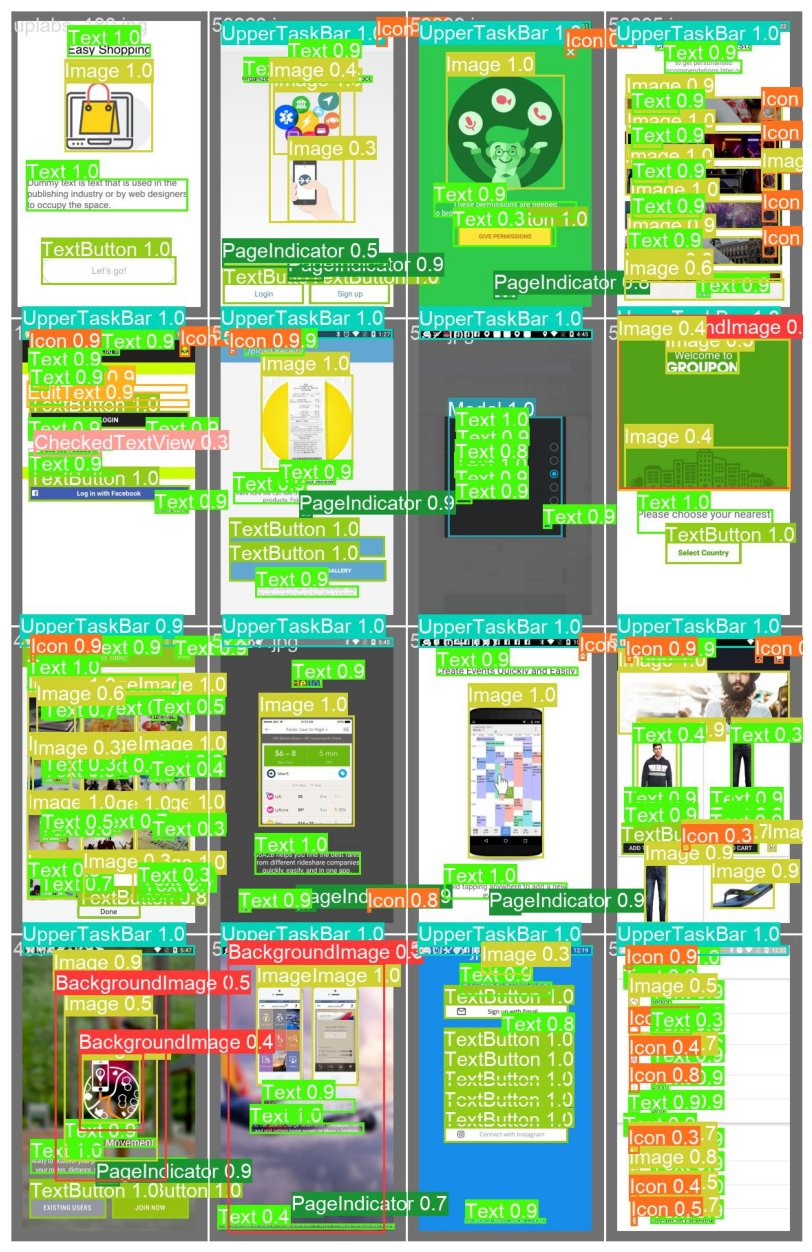

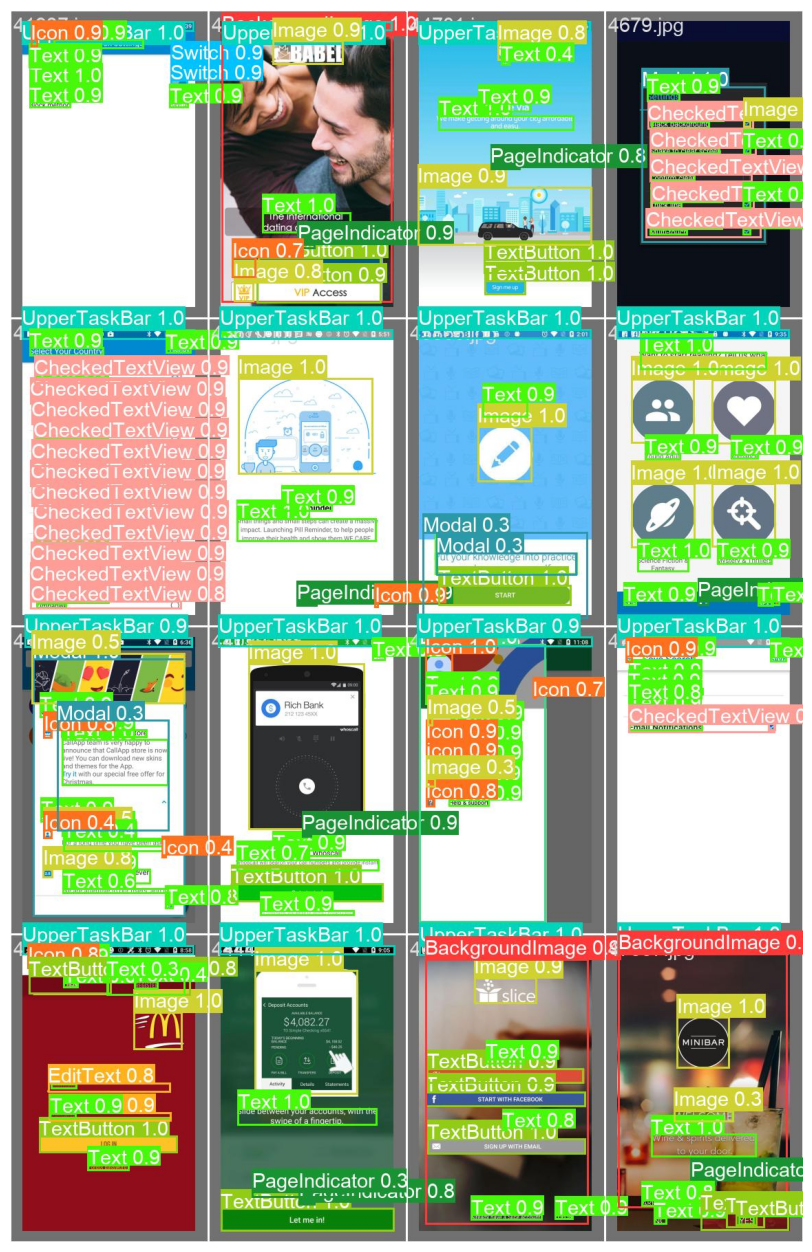

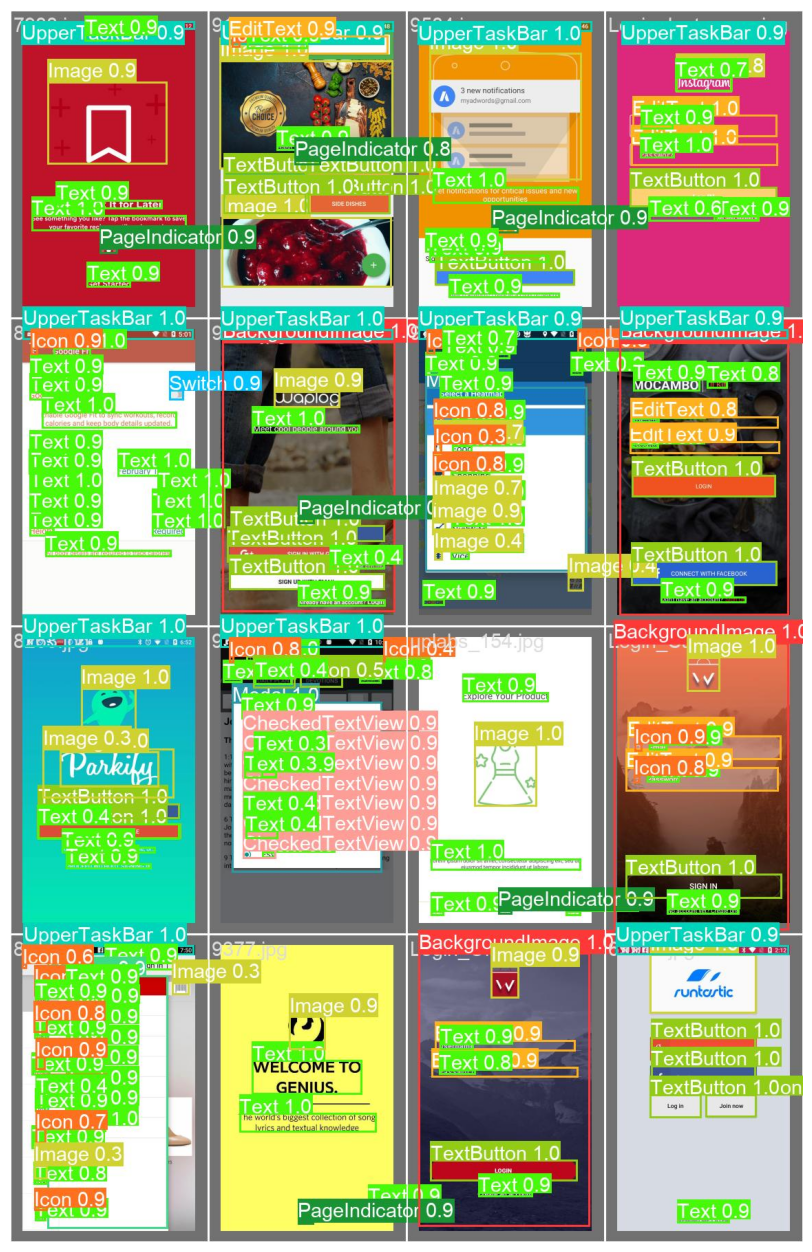

In [23]:
show_valid_results(RES_DIR)

In [25]:
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
            --source {data_path} --name {INFER_DIR}
    return INFER_DIR

def visualize(INFER_DIR):
    # Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

def visualize_inference(RES_DIR, data_path):
    visualize(inference(RES_DIR, data_path))

In [ ]:
visualize_inference(RES_DIR, 'test_images')

## YOLOv5 has a problem with spaces in the directory, so images from the following directory were placed in the test images directory: E:/Research/course research projects/data-driven software engineering/datasets/All Dataset/Merged/dataset/images/test/

Current number of inference detection directories: 0
inference_1


In [7]:
!python val.py --task test --data dataset.yaml --imgsz 416 --weights runs/train/results_300_f3/weights/best.pt --name 'test-results'

val: data=dataset.yaml, weights=['runs/train/results_300_f3/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name='test-results', exist_ok=False, half=False, dnn=False
fatal: cannot change to 'E:\Research\course': No such file or directory
YOLOv5  2023-3-11 Python-3.9.16 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

test: Scanning E:\Research\course research projects\data-driven software engineering\datasets\All Dataset\Merged\dataset\labels\test...:   0%|          | 0/455 [00:00<?, ?it/s]
test: Scanning E:\Research\course research projects\data-driven software engineering\datasets\All Dataset\Merged\dataset\labels\test... 1 images, 0 backgrounds, 0 corrupt:   0%

In [8]:
!python val.py --task val --data dataset.yaml --imgsz 416 --weights runs/train/results_300_f3/weights/best.pt --name 'val-results'


val: data=dataset.yaml, weights=['runs/train/results_300_f3/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name='val-results', exist_ok=False, half=False, dnn=False
fatal: cannot change to 'E:\Research\course': No such file or directory
YOLOv5  2023-3-11 Python-3.9.16 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

val: Scanning E:\Research\course research projects\data-driven software engineering\datasets\All Dataset\Merged\dataset\labels\validation.cache... 455 images, 0 backgrounds, 0 corrupt: 100%|##########| 455/455 [00:00<?, ?it/s]
val: Scanning E:\Research\course research projects\data-driven software engineering\datasets\All Dataset\Merged\dataset\labels\v

In [4]:
!python val.py --task test --data dataset.yaml --imgsz 416 --weights runs/train/results_300_f3/weights/last.pt --name 'test-results_lastpt'

val: data=dataset.yaml, weights=['runs/train/results_300_f3/weights/last.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name='test-results_lastpt', exist_ok=False, half=False, dnn=False
requirements: YOLOv5 requirement "seaborn>=0.11.0" not found, attempting AutoUpdate...

















requirements: 1 package updated per E:\Research\course research projects\data-driven software engineering\gui-element-detection\src\yolo\yolov5\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect

fatal: cannot change to 'E:\Research\course': No such file or directory
YOLOv5  2023-3-11 Python-3.10.9 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

test:

In [5]:
!python val.py --task val --data dataset.yaml --imgsz 416 --weights runs/train/results_300_f3/weights/last.pt --name 'val-results_lastpt'


val: data=dataset.yaml, weights=['runs/train/results_300_f3/weights/last.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name='val-results_lastpt', exist_ok=False, half=False, dnn=False
requirements: YOLOv5 requirement "seaborn>=0.11.0" not found, attempting AutoUpdate...

















requirements: 1 package updated per E:\Research\course research projects\data-driven software engineering\gui-element-detection\src\yolo\yolov5\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect

fatal: cannot change to 'E:\Research\course': No such file or directory
YOLOv5  2023-3-11 Python-3.10.9 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

val: Sc